<a href="https://www.kaggle.com/code/rubanzasilva/ps-s04e04-fastai?scriptVersionId=172994067" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<a href="https://colab.research.google.com/github/rubanzasilva/abalone_age_prediction/blob/dev/ps_s04e04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Abalone Age Prediction

Predicting the age of abalone from physical measurements.  The age of abalone is determined by cutting the shell through the cone, staining it, and counting the number of rings through a microscope -- a boring and time-consuming task.  Other measurements, which are easier to obtain, are used to predict the age.  Further information, such as weather patterns and location (hence food availability) may be required to solve the problem.

From the original data examples with missing values were removed (the majority having the predicted value missing), and the ranges of the continuous values have been scaled for use with an ANN (by dividing by 200).

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e4/sample_submission.csv
/kaggle/input/playground-series-s4e4/train.csv
/kaggle/input/playground-series-s4e4/test.csv


### Imports

In [4]:
#hide
#! [ -e /content ]

#hide
#This imports and sets up everything you will need for this notebook
#
#!pip install -Uqq fastbook
#import fastbook
#fastbook.setup_book()

#from fastbook import *
from fastai.tabular.all import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import random

from fastai.imports import *
np.set_printoptions(linewidth=130)


from pathlib import Path
import os


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
#from sklearn.metrics import root_mean_squared_error

import xgboost as xgb
from xgboost import plot_importance

import lightgbm as lgb

from ipywidgets import interact


matplotlib.rc('image', cmap='Greys')

In [5]:
!ls /kaggle/input/playground-series-s4e4

sample_submission.csv  test.csv  train.csv


In [ ]:
#set_seed(42)

In [6]:
path = Path('/kaggle/input/playground-series-s4e4/')
path

Path('/kaggle/input/playground-series-s4e4')

### Index_col

Removing the id column seems to slightly improve predictions so i go with a dataset with the id column set as the index.

In [7]:
train_df = pd.read_csv(path/'train.csv',index_col='id')
test_df = pd.read_csv(path/'test.csv',index_col='id')
sub_df = pd.read_csv(path/'sample_submission.csv',index_col='id')

# Model Architectures.

Below, i try out various models.

I have combined the steps for the different models in one codecell respectively, to see the breakdown, go through the breakdown section

Neural Network

XGBoost

In [8]:
cont_names,cat_names = cont_cat_split(train_df, dep_var='Rings')
splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))
to = TabularPandas(train_df, procs=[Categorify, FillMissing,Normalize],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names='Rings',
                   y_block=RegressionBlock(),
                   splits=splits)

X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()
model = xgb.XGBRegressor(n_estimators = 200, max_depth=6, learning_rate=0.15, subsample=0.5)
xgb_model = model.fit(X_train, y_train)
dls = to.dataloaders(bs=64)
test_dl = dls.test_dl(test_df)
preds = tensor(model.predict(test_dl.xs))
xgb_preds = preds
#submit = pd.read_csv(path/'sample_submission.csv')
#submit['Rings'] = xgb_preds
#submit.to_csv('submission.csv', index=False)
#sub = pd.read_csv('submission.csv')
mse = mean_absolute_error(y_test, model.predict(X_test))
rmse = np.sqrt(mse)
rmse

1.1202205

LightGBM

In [9]:
#cont_names,cat_names = cont_cat_split(train_df, dep_var='Rings')
#splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))
#to = TabularPandas(train_df, procs=[Categorify, FillMissing,Normalize],
                  # cat_names = cat_names,
                  # cont_names = cont_names,
                  # y_names='Rings',
                  # y_block=RegressionBlock(),
                  # splits=splits)

#X_train, y_train = to.train.xs, to.train.ys.values.ravel()
#X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

new_model = lgb.LGBMRegressor(num_leaves=31, learning_rate=0.1, n_estimators=200)
lgb_model = new_model.fit(X_train, y_train)

#dls = to.dataloaders(bs=64)
#test_dl = dls.test_dl(test_df)

new_preds = tensor(new_model.predict(test_dl.xs))
lgb_preds = new_preds


#submit = pd.read_csv(path/'sample_submission.csv')
#submit['Rings'] = xgb_preds
#submit.to_csv('submission.csv', index=False)
#sub = pd.read_csv('submission.csv')
mse = mean_absolute_error(y_test, new_model.predict(X_test))
rmse = np.sqrt(mse)
rmse

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009550 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1332
[LightGBM] [Info] Number of data points in the train set: 72492, number of used features: 8
[LightGBM] [Info] Start training from score 9.697098


1.1162307482766145

Random Forest

In [32]:
rf = RandomForestClassifier(100, min_samples_leaf=5)
rf_model = rf.fit(X_train, y_train);

#cont_names,cat_names = cont_cat_split(train_df, dep_var='Rings')
#splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))
#to = TabularPandas(train_df, procs=[Categorify, FillMissing,Normalize],
                  # cat_names = cat_names,
                  # cont_names = cont_names,
                  # y_names='Rings',
                  # y_block=RegressionBlock(),
                  # splits=splits)

#X_train, y_train = to.train.xs, to.train.ys.values.ravel()
#X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

#dls = to.dataloaders(bs=64)
#test_dl = dls.test_dl(test_df)

new_rf_preds = tensor(rf_model.predict(test_dl.xs))
rf_preds = new_rf_preds


#submit = pd.read_csv(path/'sample_submission.csv')
#submit['Rings'] = xgb_preds
#submit.to_csv('submission.csv', index=False)
#sub = pd.read_csv('submission.csv')
mse = mean_absolute_error(y_test, rf_model.predict(X_test))
rmse = np.sqrt(mse)
rmse
#mean_absolute_error(y_test, rf.predict(X_test))

1.1324082289812731

In [5]:
lgb_xgb = (xgb_preds + lgb_preds + rf_preds)/3

In [13]:
submit = pd.read_csv(path/'sample_submission.csv')
submit['Rings'] = lgb_xgb
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv')
sub

,id,Rings
0,90615,9.926594
1,90616,9.551116
2,90617,10.014128
3,90618,10.307645
4,90619,7.584415
...,...,...
60406,151021,6.342990
60407,151022,9.465271
60408,151023,13.063795
60409,151024,13.618238


# Breakdown

### Initial Exploratory Data Analysis

**Variable description from the initial UCI dataset repository**

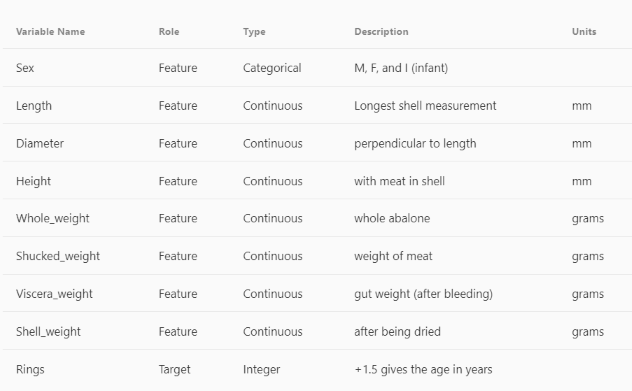


In [ ]:
train_df.head()

Categorical variable exploration

In [ ]:
train_df.describe(include=[object])

In [ ]:
train_df['Sex'].unique()

In [ ]:
train_df['Sex'].hist(figsize=(6,2));

In [ ]:
sex_classes_count = train_df['Sex'].value_counts()
sex_classes_count.plot(kind='pie',figsize=(10,4));

Sex has 3 values ??
Turns out Abalone's sex can change with time or over their lifespans.

The dataset categorises sex into 3 categories i.e. Male, Female and Infant.
We also notice that infant has the most values.

In [ ]:
train_df.describe()

In [ ]:
dep_classes_count = train_df['Rings'].value_counts()
dep_classes_count

In [ ]:
train_df['Rings'].hist()

In [ ]:
dep_classes_count = train_df['Diameter'].value_counts()
dep_classes_count

In [ ]:
train_df['Diameter'].hist()

In [ ]:
dep_classes_count.plot(kind='pie')

In [ ]:
train_df.hist(figsize=(20,15));

#### Feature Engineering

Drop Sex

In [ ]:
!ls

In [ ]:
train_df.drop('Sex', axis=1 , inplace=True)
test_df.drop('Sex', axis=1 , inplace=True)

### TabularPandas Object


We create an instance of a TabularPandas Object,to which is a fastai dataframe wrapper that stores all the information about our dataset such as which columns are continous, categorical, and our dependent variables.

This instance also stores and applies the set transformations to our data.

cont_cat_split helps us split our data into continuos and categorical variables.

In [23]:
cont_names,cat_names = cont_cat_split(train_df, dep_var='Rings')

We split our data into training and validation with fastai's RandomSplitter which does an 80/20 random split.

In [24]:
splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))

In [25]:
to = TabularPandas(train_df, procs=[Categorify, FillMissing,Normalize],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names='Rings',
                   y_block=RegressionBlock(),
                   splits=splits)

In [26]:
to.xs.iloc[:2]

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight
id,,,,,,,,
84205,1,1.207735,1.103982,1.429712,1.912049,1.548260,1.588974,1.586393
58763,2,-0.526031,-0.629928,-0.799675,-0.729382,-0.716236,-0.614238,-0.737101


In [27]:
dls = to.dataloaders(bs=64)

In [28]:
dls.show_batch()

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,I,0.475,0.365,0.105,0.4330,0.1575,0.0885,0.1470,10.0
1,F,0.625,0.490,0.185,1.1415,0.3935,0.2385,0.3200,18.0
2,M,0.535,0.425,0.170,0.8695,0.3155,0.1685,0.2500,15.0
3,M,0.590,0.470,0.130,0.9905,0.4115,0.1960,0.2550,13.0
4,M,0.715,0.575,0.225,2.5085,0.7625,0.4050,0.5950,19.0
5,F,0.560,0.450,0.145,0.8775,0.3750,0.2285,0.2300,10.0
6,F,0.355,0.260,0.075,0.1875,0.0815,0.0475,0.0580,6.0
7,I,0.215,0.165,0.060,0.0525,0.0210,0.0065,0.0150,4.0
8,M,0.495,0.390,0.135,0.6335,0.3035,0.1285,0.1600,8.0
9,I,0.455,0.370,0.110,0.5365,0.2855,0.1245,0.1275,10.0


In [29]:
learn = tabular_learner(dls, metrics=rmse)

SuggestedLRs(slide=0.04786301031708717, valley=0.010964781977236271)

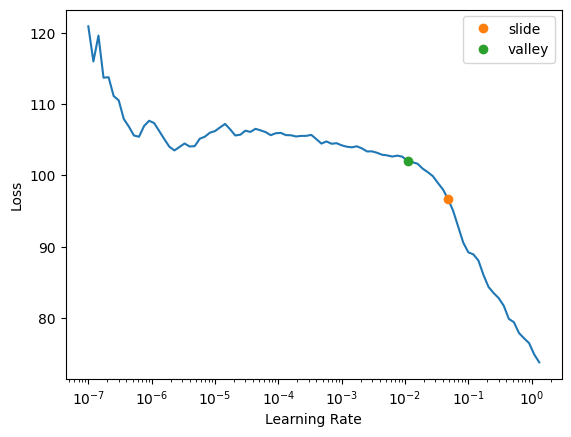

In [30]:
learn.lr_find(suggest_funcs=(slide,valley))

In [31]:
learn.fit_one_cycle(10,0.02)

epoch,train_loss,valid_loss,None,time


TypeError: Exception occured in `Recorder` when calling event `after_batch`:
	'numpy.float64' object is not callable

In [ ]:
#learn.fit_one_cycle(9,0.11)

In [ ]:
learn.show_results()

In [ ]:
dl = learn.dls.test_dl(test_df)

In [ ]:
nn_preds = learn.get_preds(dl=dl)

In [ ]:
a_preds, _ = learn.get_preds(dl=dl)
nn_preds_y = a_preds.squeeze(1)

In [ ]:
nn_preds_x = learn.get_preds()[0]

In [ ]:
X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

In [ ]:
mse = mean_absolute_error(y_test, nn_preds_x)
rmse = np.sqrt(mse)
rmse

In [ ]:
learn = tabular_learner(dls, metrics=rmse)
learn.lr_find(suggest_funcs=(slide,valley))

In [ ]:
#learn.fit_one_cycle(10,0.02)

In [ ]:
mse = mean_absolute_error(y_test, nn_preds_x)
rmse = np.sqrt(mse)
rmse

In [ ]:
#rmse(nn_preds_x, tensor(y_test))

In [ ]:
#rmse(nn_preds_x, tensor(y_test))

In [ ]:
!ls

In [ ]:
#target_preds = nn_preds[0]

In [ ]:
#test_df['Rings'] = target_preds

#test_df.to_csv('submission.csv', columns=['id','Rings'], index=False)

#submission = pd.read_csv('submission.csv')
#submission.head()

In [ ]:
ls

In [ ]:
#!kaggle competitions submit -c playground-series-s4e4 -f submission.csv -m "Neural Network Sub 3 with id column + no random seed "

####Neural Network without id column

In [ ]:
target_preds = nn_preds[0]

test_df['Rings'] = target_preds

test_df.to_csv('submission.csv', columns=['Rings'], index=True, index_label='id')

submission = pd.read_csv('submission.csv')
submission.head()

In [ ]:
!ls

In [ ]:
#!kaggle competitions submit -c playground-series-s4e4 -f submission.csv -m "Neural Network Sub 7 with no id and sex column "

###Neural Network Ensemble

In [ ]:
learn.lr_find(suggest_funcs=(slide,valley))

In [ ]:
dl = learn.dls.test_dl(test_df)

In [ ]:
def ensemble():
    learn = tabular_learner(dls, metrics=accuracy_multi, layers=[20,20,20,20], loss_func = BCEWithLogitsLossFlat())
    with learn.no_bar(),learn.no_logging(): 
        learn.fit(16, lr=0.07)
        learn.fit_one_cycle(10, slice(0.05, 0.05/5))
    return learn.get_preds(dl=tst_dl)[0]

In [ ]:
def ensemble():
    learn = tabular_learner(dls, metrics=rmse)
    with learn.no_bar(),learn.no_logging(): learn.fit(9, slice(1e-1,1e-3))
    return learn.get_preds(dl=dl)[0]

In [ ]:
#learns = [ensemble() for _ in range(5)]

In [ ]:
ens_preds = torch.stack(learns).mean(0)

In [ ]:
ens_preds, _ = learn.get_preds(dl=dl)

In [ ]:
ens_preds_y = ens_preds.squeeze(1)
ens_preds_y

In [ ]:
mse = mean_absolute_error(y_test, nn_preds_x)
rmse = np.sqrt(mse)
rmse

In [ ]:
ens_preds_y[0]

In [ ]:
#target_preds = ens_preds_y[0]

#test_df['Rings'] = target_preds

#test_df.to_csv('submission.csv', columns=['Rings'], index=True, index_label='id')

#submission = pd.read_csv('submission.csv')
#submission.head()

In [ ]:
target_preds = ens_preds_y

test_df['Rings'] = target_preds

test_df.to_csv('submission.csv', columns=['Rings'], index=True, index_label='id')

submission = pd.read_csv('submission.csv')
submission.head()

In [ ]:
!ls

In [ ]:
!kaggle competitions submit -c playground-series-s4e4 -f submission.csv -m "Neural Network ensemble preds Sub 2 with no id column + no random seed "

In [ ]:
submission = pd.DataFrame({
     # Assuming 'Id' is the identifier column
    'target': ens_preds
})

# Save your submission to a CSV file
submission.to_csv('submission.csv', index=False)

In [ ]:
def subm(preds, suff):
    test_df['Rings'] = preds
    sub_df = test_df[['id','Rings']]
    sub_df.to_csv(f'sub{suff}.csv', index=False)

subm(ens_preds, 'mission')

In [ ]:
#sub_df = pd.DataFrame(ens_preds, columns='Rings')
#sub_df['id'] = test_df['id']

# Reorder the columns to match the submission format
#sub_df = sub_df[['id', 'Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']]

# Save the submission DataFrame as a CSV file
#sub_df.to_csv('rf_submission.csv', index=False)

In [ ]:
#targets ='Rings'
#test_df[targets] = ens_preds
#sub_df['id'] = test_df['id']

#test_df.to_csv('submission.csv', columns=['Rings'], index=False)

#ens_sub = pd.read_csv('submission.csv')
#ens_sub.head()

### Random Forest

In [ ]:
rf = RandomForestClassifier(100, min_samples_leaf=5)
rf.fit(X_train, y_train);
#mean_absolute_error(y_test, rf.predict(X_test))

In [ ]:
!ls

In [ ]:
X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

In [ ]:
rf = RandomForestClassifier(100, min_samples_leaf=5)
rf.fit(X_train, y_train);
#mean_absolute_error(y_test, rf.predict(X_test))

In [ ]:
mse = mean_absolute_error(y_test, rf.predict(X_test))
rmse = np.sqrt(mse)
rmse

In [ ]:
mse = mean_absolute_error(y_test, nn_preds_x)
rmse = np.sqrt(mse)
rmse

In [ ]:
#rf_preds = rf.predict(X_test)

In [ ]:
#rmse(rf_preds, tensor(y_test))

#### Feature Importance

In [ ]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [ ]:
rf_feat_importance(rf, X_train)

In [ ]:
fi = rf_feat_importance(rf, X_train)
fi[:10]

In [ ]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

In [ ]:
pd.DataFrame(dict(cols=X_train.columns, imp=rf.feature_importances_)).plot('cols', 'imp', 'barh');

In [ ]:
fi = rf_feat_importance(rf, X_train)
fi[:10]

#### Remove low importance variables

In [ ]:
to_keep = fi[fi.imp>0.05].cols
len(to_keep)


In [ ]:
to_keep

In [ ]:
X_imp = X_train[to_keep]
X_test_new = X_test[to_keep]

In [ ]:
rf.fit(X_imp, y_train);
#m = rf(X_imp, y)

In [ ]:
rf_preds = rf.predict(X_test_new)

In [ ]:
mse = mean_absolute_error(y_test, rf.predict(X_test_new))
mse

In [ ]:
rmse = np.sqrt(mse)
rmse

In [ ]:
#rf_preds = rf.predict(X_test_new)
#rmse(rf_preds, tensor(y_test))

In [ ]:
X_test

In [ ]:
rf = RandomForestClassifier(100, min_samples_leaf=5)
rf.fit(X_train, y_train);
#mean_absolute_error(y_test, rf.predict(X_test))

def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

fi = rf_feat_importance(rf, X_train)

def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

to_keep = fi[fi.imp>0.005].cols

In [ ]:
X_test_new


Shell weight and Whole weight seem to be the most importatant features closely followed by Whole Weight. 1 And Whole Weight. 2.

Sex seems to be the least important predictor.

In [ ]:
# Training dataset
numeric_columns_train = X_train.select_dtypes(include=np.number)
corr_train = numeric_columns_train.corr(method='pearson')
mask_train = np.triu(np.ones_like(corr_train))
sns.heatmap(corr_train, annot=True, fmt='.2f', mask=mask_train, cmap='Spectral', cbar=None, linewidth=2)
plt.tight_layout()
plt.show()

Darker Colors: Indicate stronger correlations. The closer the color is to the maximum intensity (e.g., red or orange for positive correlations, blue or green for negative correlations), the stronger the correlation 1.


Lighter Colors: Indicate weaker correlations. The closer the color is to the minimum intensity (e.g., white or light blue), the weaker the correlation 1.

Try dropping sex column.
or Diameter
or diameter and whole weight

In [ ]:
from fastai.tabular.all import cluster_columns

In [ ]:
cluster_columns(xs_imp)

####  Making Predictions

In [ ]:
dls = to.dataloaders(bs=64)

In [ ]:
!ls

In [ ]:
test_dl = dls.test_dl(test_df)

In [ ]:
preds = tensor(rf.predict(test_dl.xs))
rf_preds = preds

In [ ]:
#rmse(rf_preds, tensor(y_test))

Kaggle submission code from


https://www.kaggle.com/code/nguyncaoduy/fastai-tabular-regression-model-nn-xgb



In [ ]:
submit = pd.read_csv(path/'sample_submission.csv')
submit['Rings'] = rf_preds # nn_preds
submit.head()

In [ ]:
submit.to_csv('submission.csv', index=False)

In [ ]:
!rm submission.csv

In [ ]:
!ls

In [ ]:
sub = pd.read_csv('submission.csv')
sub.head()

In [ ]:
!kaggle competitions submit -c playground-series-s4e4 -f submission.csv -m "random forest initial subm trial 3 with no id column in general model nb"

## XGBoost

In [ ]:
X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

In [ ]:
model = xgb.XGBRegressor(n_estimators = 200, max_depth=6, learning_rate=0.15, subsample=0.5)

In [ ]:
xgb_model = model.fit(X_train, y_train)

XGBoost Feature Importance

In [ ]:
plot_importance(xgb_model);

Similar to the random forest, sex seems to be the least important predictor.
Length seems to be the only differing facotr factor from the Random forst in importance.

In [ ]:
#xgb_preds = tensor(model.predict(X_test))

In [ ]:
#rmse(xgb_preds, tensor(y_test))

In [ ]:
dls = to.dataloaders(bs=64)

In [ ]:
test_dl = dls.test_dl(test_df)

In [ ]:
preds = tensor(model.predict(test_dl.xs))
xgb_preds = preds

rmse with train set with sex column removed.

In [ ]:
xgb_preds

In [ ]:
mse = mean_absolute_error(y_test, model.predict(X_test))
rmse = np.sqrt(mse)
rmse

In [ ]:
!ls

XGBoost Submission code

In [ ]:
X_train

In [ ]:
submit = pd.read_csv(path/'sample_submission.csv')
submit['Rings'] = xgb_preds # nn_preds
submit.head()

In [ ]:
submit.to_csv('submission.csv', index=False)

In [ ]:
!rm submission.csv

In [ ]:
sub = pd.read_csv('submission.csv')
sub.head()

In [ ]:
#!kaggle competitions submit -c playground-series-s4e4 -f submission.csv -m "xgboost initial subm trial 5 without id column"

###General Model Ensemble

XGBoost + Random Forest

In [ ]:
avgs = (xgb_preds + rf_preds) / 2

In [ ]:
avgs = (xgb_preds + nn_preds_y) / 2

In [ ]:
avgs

In [ ]:
xgb_preds.shape,rf_preds.shape,nn_preds_y.shape

In [ ]:
avgs = (xgb_preds + nn_preds_y + rf_preds) / 3

In [ ]:
ens_preds_y

In [ ]:
avgs_ens = (xgb_preds + ens_preds_y + rf_preds) / 3

avgs_ens submission

In [ ]:
submit = pd.read_csv(path/'sample_submission.csv')
submit['Rings'] = avgs_ens # nn_preds
submit.head()

In [ ]:
submit.to_csv('submission.csv', index=False)

In [ ]:
!ls

In [ ]:
sub = pd.read_csv('submission.csv')
sub.head()

In [ ]:
avgs.shape

In [ ]:
!ls

avgs submission

In [ ]:
submit = pd.read_csv(path/'sample_submission.csv')
submit['Rings'] = avgs # nn_preds
submit.head()

In [ ]:
submit.to_csv('submission.csv', index=False)

In [ ]:
!ls

In [ ]:
sub = pd.read_csv('submission.csv')
sub.head()

In [ ]:
!kaggle competitions submit -c playground-series-s4e4 -f submission.csv -m "rf preds + xgb_preds sub 1 with no id column all adjustment to test set preds"

In [ ]:
!kaggle competitions submit -c playground-series-s4e4 -f submission.csv -m "xgboost preds, nn_preds sub 1 with no id column all adjustment to test set preds"

In [ ]:
#!kaggle competitions submit -c playground-series-s4e4 -f submission.csv -m "xgboost preds, nn_preds + random forest preds sub 3 with no id column all adjustment to test set preds"

#### Full Notebook

In [ ]:
cont_names,cat_names = cont_cat_split(train_df, dep_var='Rings')
splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))
to = TabularPandas(train_df, procs=[Categorify, FillMissing,Normalize],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names='Rings',
                   y_block=RegressionBlock(),
                   splits=splits)

X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()
model = xgb.XGBRegressor(n_estimators = 200, max_depth=6, learning_rate=0.15, subsample=0.5)
xgb_model = model.fit(X_train, y_train)
dls = to.dataloaders(bs=64)
test_dl = dls.test_dl(test_df)
preds = tensor(model.predict(test_dl.xs))
xgb_preds = preds
submit = pd.read_csv(path/'sample_submission.csv')
submit['Rings'] = xgb_preds 
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv')
mse = mean_absolute_error(y_test, model.predict(X_test))
rmse = np.sqrt(mse)
rmse

In [ ]:
cont_names,cat_names = cont_cat_split(train_df, dep_var='Rings')
splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))
to = TabularPandas(train_df, procs=[Categorify, FillMissing,Normalize],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names='Rings',
                   y_block=RegressionBlock(),
                   splits=splits)

X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

new_model = lgb.LGBMRegressor(num_leaves=31, learning_rate=0.1, n_estimators=200)
lgb_model = new_model.fit(X_train, y_train)

#dls = to.dataloaders(bs=64)
#test_dl = dls.test_dl(test_df)

new_preds = tensor(new_model.predict(test_dl.xs))
lgb_preds = new_preds


#submit = pd.read_csv(path/'sample_submission.csv')
#submit['Rings'] = xgb_preds 
#submit.to_csv('submission.csv', index=False)
#sub = pd.read_csv('submission.csv')
mse = mean_absolute_error(y_test, new_model.predict(X_test))
rmse = np.sqrt(mse)
rmse